In [2]:
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os
# Create a MirroredStrateg, If Multi-GPU available
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' 
tf.config.set_soft_device_placement(True)
# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2']) 
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from livelossplot.keras import PlotLossesCallback
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tqdm import tqdm
import efficientnet.keras as efn
import h5py, glob, re, cv2, math, matplotlib, pickle, gc
import tensorflow.keras as keras
import pandas as pd
from pandas import read_csv
import numpy as np
from scipy import stats
import itertools, random
from collections import Counter
# from cnn_utils import *
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from PIL import Image  
import pdb
from statistics import mode 
from IPython.display import clear_output

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

np.random.seed(1)
# Setting the seed for python random numbers
random.seed(1254)
# Setting the graph-level random seed.
tf.random.set_seed(89)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
!CUDA_VISIBLE_DEVICES=2

# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2'])
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# def setup_multi_node_training(): # IMPORTANT: SET UP TF_CONFIG FOR MULTINODE TRAINING HERE os.environ[“TF_FORCE_GPU_ALLOW_GROWTH”] = “true” tf.config.set_soft_device_placement(True) mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(tf.distribute.experimental.CollectiveCommunication.NCCL) # Constructs the configuration run_config = tf.estimator.RunConfig( train_distribute=mirrored_strategy, ) return run_config
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [100]:
num_class = 9
max_num_target = 3
print('num_class:', num_class)
print('num_target:', num_target)

num_class: 9
num_target: 3


## Data loading functions 

In [4]:
def load_pkl(filename):
    with open(filename, 'rb') as input:
        data = pickle.load(input)
    return data

In [5]:
def load_hdf5(filename):
    return h5py.File(filename, "r")

## Callbacks

In [114]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=20, restore_best_weights=True
)

In [16]:
def checkpoint_filepath(filename):
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = filename,
        save_weights_only = False,
        monitor = 'val_accuracy',
        mode = 'max',
        save_best_only = True)
    return checkpoint_callback

## Data generators

In [7]:
def data_generator(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data.shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples = data[offset:offset+batch_size]
            label = labels[offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []
            # For each example
            for i in range(0,batch_samples.shape[0]):
                X_train.append(batch_samples[i])
                y_train.append(label[i])

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)

            # yield the next training batch            
            yield X_train, y_train

In [8]:
def data_generator_pred(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data.shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples = data[offset:offset+batch_size]
            label = labels[offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []
            # For each example
            for i in range(0,batch_samples.shape[0]):
                X_train.append(batch_samples[i])
                y_train.append(label[i])

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)

            # yield the next training batch            
            yield X_train

## Single act network

In [136]:
def nn_singleact(input_shapex):
    inputlayer1 = Input(shape = input_shapex)
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(inputlayer1)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Flatten()(x)
    x = Dense(120, activation='relu')(x)
    x = Dense(240, activation='relu')(x)
    x = Reshape(target_shape = (max_num_target, 240//max_num_target))(x)
#     x = Dropout(0.5)(x)
    out1 = TimeDistributed(Dense(num_class,activation='sigmoid'))(x)
#     x = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(x)
#     out1 = Dense(num_class,activation='softmax')(x)
#         out1 = TimeDistributed(Dense(num_class,activation='softmax'))(x, mask=maskinput)
#         model = keras.Model(inputs = [inputlayer1,maskinput], outputs = [out1])#, out2, out3])
    model = keras.Model(inputs = [inputlayer1], outputs = [out1])#, out2, out3])
    opt = Adam(lr=1e-3, decay=1e-3 / 200)
    model.compile(loss = 'binary_crossentropy', optimizer=opt, metrics = ['accuracy'])
    return model 

In [137]:
# def cnn(input_shapex):
#     inputlayer1 = Input(shape = input_shapex)
#     x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(inputlayer1)
#     x = MaxPooling2D(pool_size=(2,2))(x)
#     x = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(x)
#     x = MaxPooling2D(pool_size=(2,2))(x)
#     x = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')(x)
#     x = MaxPooling2D(pool_size=(2,2))(x)
#     x = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')(x)
#     x = MaxPooling2D(pool_size=(2,2))(x)
    
#     return x 

In [138]:
# def tpn(base_layers, max_num_target):
#     x = Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu')(base_layers)
    
#     # classification layers to predict if there is target or not
#     x_class = Conv2D(max_num_target, kernel_size=(1, 1), activation='sigmoid')(x)
    
#     return [x_class, base_layers]

In [139]:
# data

x = load_hdf5('datasets/single_act.hdf5')
x_train, x_test, y_train, y_test = [x['train_img'], x['test_img'], x['train_labels'], x['test_labels']]

y_temp = np.zeros((y_train.shape[0], max_num_target, num_class))
y_temp[:, 0, :] = y_train
y_train = y_temp

y_temp = np.zeros((y_test.shape[0], max_num_target, num_class))
y_temp[:, 0, :] = y_test
y_test = y_temp

print('Data shapes:')
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

Data shapes:
(380, 128, 128, 3)
(380, 3, 9)
(96, 128, 128, 3)
(96, 3, 9)


In [140]:
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
print('Input shape: ', input_shape)

Input shape:  (128, 128, 3)


In [149]:
batch_size = 128
model_name = 'models/single_act'
checkpoint_callback = checkpoint_filepath(model_name)
nn = nn_singleact(input_shape)

train_dataset = data_generator(x_train, y_train, batch_size)
validation_dataset = data_generator(x_test, y_test, batch_size)

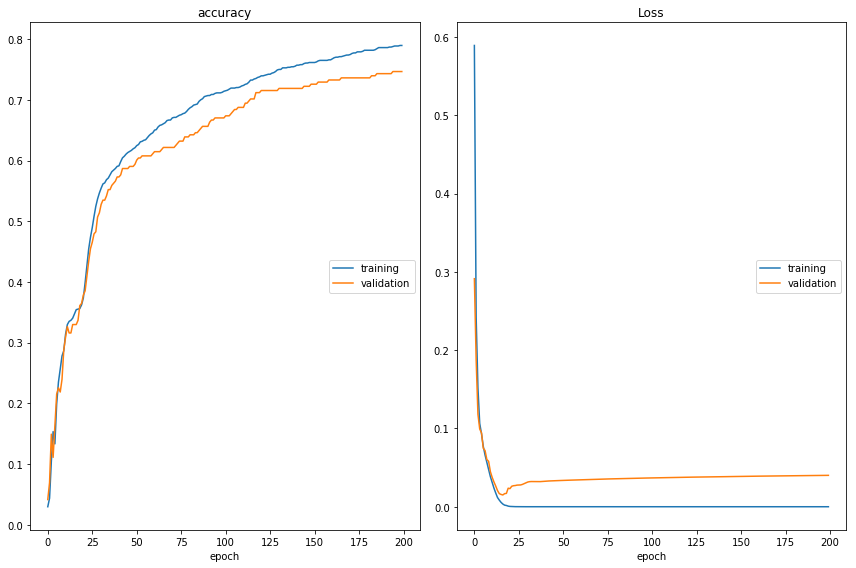

accuracy
	training         	 (min:    0.030, max:    0.789, cur:    0.789)
	validation       	 (min:    0.042, max:    0.747, cur:    0.747)
Loss
	training         	 (min:    0.000, max:    0.589, cur:    0.000)
	validation       	 (min:    0.015, max:    0.291, cur:    0.040)
3/3 [==============================] - 1s 181ms/step - loss: 5.6810e-07 - accuracy: 0.7895 - val_loss: 0.0401 - val_accuracy: 0.7465


In [150]:
# history = nn.fit(
#     np.array(x_train), np.array(y_train),
#     validation_data = [np.array(x_test), np.array(y_test)],
#     batch_size = batch_size,
#     epochs=200,
#     shuffle=False,
#     callbacks=[early_stopping, PlotLossesKerasTF(), checkpoint_callback],
#     verbose = 1
# )

history = nn.fit(
    train_dataset,
    validation_data=validation_dataset,
#     batch_size = 1,
    epochs=200,
    shuffle = False,
    steps_per_epoch = math.ceil(len(y_train) / batch_size), validation_steps = math.ceil(len(y_test) / batch_size),
    callbacks=[PlotLossesKerasTF(), checkpoint_callback],
    verbose = 1
)

In [151]:
nn2 = keras.models.load_model(model_name)
nn2.evaluate(validation_dataset, steps = math.ceil(len(y_test) / batch_size))

1/1 [==============================] - 0s 2ms/step - loss: 0.0400 - accuracy: 0.7465


[0.03999824449419975, 0.7465277910232544]

In [152]:
pred_dataset = data_generator_pred(x_test, y_test)
preds = np.array([np.squeeze(nn2.predict(next(pred_dataset))) for i in tqdm(range(len(y_test)), position=0)])
preds.shape

100%|██████████| 96/96 [00:03<00:00, 30.37it/s]


(96, 3, 9)

In [161]:
idx = 1
print(np.argmax(preds[idx], -1))
print(np.argmax(y_test[idx], -1))

[7 0 0]
[7 0 0]


In [154]:
y_test[0]

array([[0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])